In [1]:
library(tidyverse)
library(MASS)
library(glmnet)
library(rlist)
library(superheat)

source('./simulation_utils.R')

options(repr.plot.width=6, repr.plot.height=4) # plot sizes in this notebook


Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-13

Loading required package: caret
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [2]:
save_figs <- TRUE

In [3]:
set.seed(5645654)

# Load the fixed parameters 

In [4]:
load('./simulation_results/fixed_params/lasso_fixed_params.RData')

In [5]:
ls()

[1] "beta_full"             "choose_joint_lambda_k" "choose_lambda_cv"     
 [4] "choose_lambda_ic"      "compute_sigma2_hat"    "covar_x"              
 [7] "d"                     "draw_cs_vs_sample"     "draw_linear_responses"
[10] "get_copas_k"           "get_mspe"              "get_slope"            
[13] "get_two_step_cv_k"     "mu_x"                  "n_cs"                 
[16] "n_vs"                  "outfile"               "save_figs"            
[19] "x_cs"                  "x_cs_"

In [6]:
# superheat(x_cs)

In [7]:
# beta_full

In [8]:
# results directory
results_dir <- './simulation_results/lasso_sparsity_results/'

In [9]:
file_list <- list.files(path = results_dir, pattern = '*.rds')

In [10]:
file_list

[1] "lasso_sim_results_sigma5_sparsity830.rds"
[2] "lasso_sim_results_sigma5_sparsity860.rds"
[3] "lasso_sim_results_sigma5_sparsity890.rds"
[4] "lasso_sim_results_sigma5_sparsity920.rds"
[5] "lasso_sim_results_sigma5_sparsity950.rds"
[6] "lasso_sim_results_sigma5_sparsity980.rds"

In [11]:
sparsities <- c(830, 860, 890, 920, 950, 980)

In [12]:
s <- 1000 - sparsities

In [13]:
get_results_across_sigma <- function(results_dir, name){
    file_list <- list.files(path = results_dir, pattern = '*.rds')
    
    result_vec <- c()
    sparsities <- c()
    for(i in 1:length(file_list)){
        result_list <- list.load(paste0(results_dir, file_list[i]))
        
        result_vec <- c(result_vec, result_list[[name]])
        
        # forgot to save these in the earlier results :/
        sparsities <- c(sparsities, rep(s[i], length(result_list[[name]])))
        
    }
    return(list(results = result_vec, 
               sparsities = sparsities))
}

In [14]:
slopes <- c()
sparsities <- c()
method <- c()

lambda_only_slopes <- get_results_across_sigma(results_dir, 'lambda_only_slope_vs')
slopes <- c(slopes, lambda_only_slopes$results)
sparsities <- c(sparsities, lambda_only_slopes$sparsities)
method <- c(method, rep('lasso', length(lambda_only_slopes$sparsities)))

joint_slopes <- get_results_across_sigma(results_dir, 'joint_slope_vs')
slopes <- c(slopes, joint_slopes$results)
sparsities <- c(sparsities, joint_slopes$sparsities)
method <- c(method, rep('joint', length(lambda_only_slopes$sparsities)))

copas_result_dir <- './simulation_results/copas_lasso_results/varying_sparsity/'
copas_slopes <- get_results_across_sigma(copas_result_dir, 'copas_slope_vs')
slopes <- c(slopes, copas_slopes$results)
sparsities <- c(sparsities, copas_slopes$sparsities)
method <- c(method, rep('Copas', length(copas_slopes$sparsities)))

two_step_dir <- './simulation_results/two_step_lasso_results/varying_sparsity/'
two_step_slopes <- get_results_across_sigma(two_step_dir, 'two_step_slope_vs')
slopes <- c(slopes, two_step_slopes$results)
sparsities <- c(sparsities, two_step_slopes$sparsities)
method <- c(method, rep('two_step', length(two_step_slopes$sparsities)))

slopes_df <- data.frame(slopes = slopes, 
                       sparsities = sparsities, 
                       method = method)

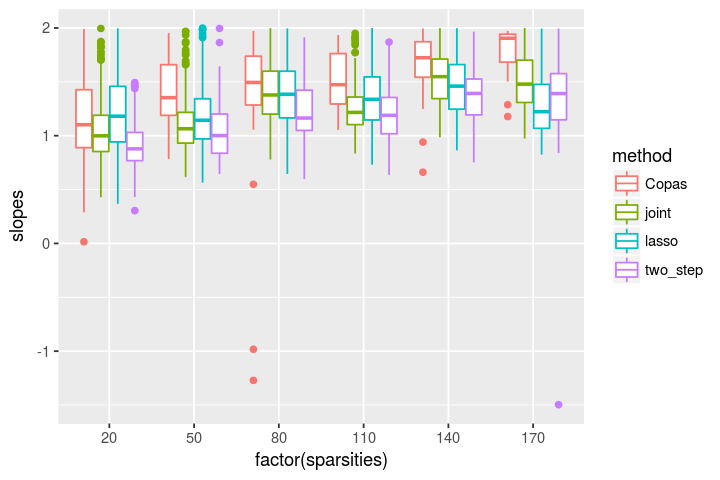

In [15]:
slopes_df %>% 
    filter(slopes < 2, slopes > -2) %>%
    ggplot() + 
        geom_boxplot(aes(x = factor(sparsities), y = slopes, colour = method), position=position_dodge(width=0.8))

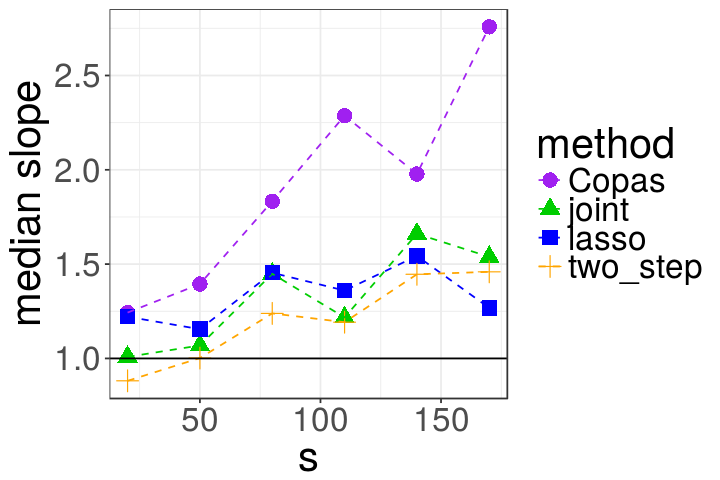

In [16]:
slopes_df %>% 
    group_by(sparsities, method) %>% 
    summarize(median_slope = median(slopes, na.rm = TRUE)) %>%
    ggplot(aes(x = sparsities, y = median_slope)) + 
        geom_point(aes(color = method, shape = method), size = 4) + 
        geom_line(aes(color = method), linetype = 'dashed')  + 
        scale_color_manual(values = c('purple', 'green3', 'blue', 'orange')) + 
        geom_hline(yintercept = 1.0) + 
        ylab('median slope') + xlab('s') + theme_bw() + 
        theme(text = element_text(size = 25), plot.title = element_text(hjust = 0.5))

if(save_figs){
    ggsave('../writing/lasso_figures/slope_vs_sparsity.png', height = 6, width = 9)
}

In [17]:
mspes <- c()
sparsities <- c()
method <- c()

lambda_only_mspes <- get_results_across_sigma(results_dir, 'lambda_only_mspe_vs')
mspes <- c(mspes, lambda_only_mspes$results)
sparsities <- c(sparsities, lambda_only_mspes$sparsities)
method <- c(method, rep('lasso', length(lambda_only_mspes$sparsities)))

joint_mspes <- get_results_across_sigma(results_dir, 'joint_mspe_vs')
mspes <- c(mspes, joint_mspes$results)
sparsities <- c(sparsities, joint_mspes$sparsities)
method <- c(method, rep('joint', length(lambda_only_mspes$sparsities)))

copas_result_dir <- './simulation_results/copas_lasso_results/varying_sparsity/'
copas_mspes <- get_results_across_sigma(copas_result_dir, 'copas_mspe_vs')
mspes <- c(mspes, copas_mspes$results)
sparsities <- c(sparsities, copas_mspes$sparsities)
method <- c(method, rep('Copas', length(copas_mspes$sparsities)))

two_step_dir <- './simulation_results/two_step_lasso_results/varying_sparsity/'
two_step_mspes <- get_results_across_sigma(two_step_dir, 'two_step_mspe_vs')
mspes <- c(mspes, two_step_mspes$results)
sparsities <- c(sparsities, two_step_mspes$sparsities)
method <- c(method, rep('two_step', length(two_step_mspes$sparsities)))

mspes_df <- data.frame(mspe = mspes, 
                       sparsity = sparsities, 
                       method = method)

In [18]:
mspes_df %>% 
    group_by(sparsity, method) %>% 
    summarize(median_mspe = median(mspe, na.rm = TRUE)) %>% filter(method == 'Copas')



sparsity,method,median_mspe
20,Copas,38.57570
50,Copas,54.70042
80,Copas,73.24486
110,Copas,101.11901
140,Copas,127.93706
170,Copas,155.67785


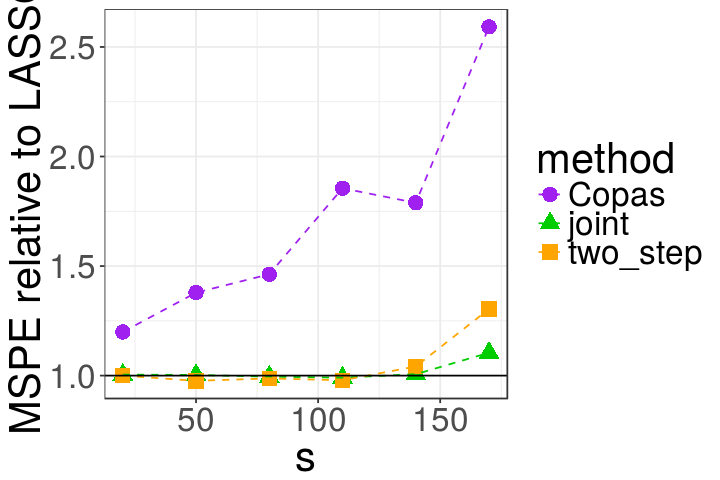

In [20]:
mspes_df %>% 
    group_by(sparsity, method) %>% 
    summarize(median_mspe = median(mspe, na.rm = TRUE)) %>% 
     spread(method, median_mspe) %>% 
     mutate(Copas = Copas / lasso, joint = joint / lasso, two_step = two_step / lasso)  %>% 
    gather(key = 'method', value = 'median_mspe', joint, lasso, two_step, Copas) %>% 
    filter(method != 'lasso')  %>% 
    filter(median_mspe < 3) %>%
    ggplot(aes(x = sparsity, y = median_mspe)) + 
        geom_point(aes(color = method, shape = method), size = 4) + 
        geom_line(aes(color = method), linetype = 'dashed')  + 
        scale_color_manual(values = c('purple', 'green3', 'orange')) + 
        geom_hline(yintercept = 1.0) + 
        ylab('MSPE relative to LASSO') + xlab('s') + theme_bw() + 
        theme(text = element_text(size = 25), plot.title = element_text(hjust = 0.5))

if(save_figs){
    ggsave('../writing/lasso_figures/mspe_vs_sparsity.png', height = 6, width = 9)    
}
